In [34]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [35]:
import numpy as np
import pandas as pd

In [36]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [37]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [38]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [39]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [40]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [41]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [42]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [43]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
first_date = session.query(Measurement.date).order_by(Measurement.date).first()
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
twelve_months = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)
twelve_months_prcp = session.query(Measurement.date, func.avg(Measurement.prcp)).\
                    filter(Measurement.date >= twelve_months).\
                    group_by(Measurement.date).all()
twelve_months_prcp



[('2016-08-24', 1.5549999999999997),
 ('2016-08-25', 0.07714285714285715),
 ('2016-08-26', 0.016666666666666666),
 ('2016-08-27', 0.06399999999999999),
 ('2016-08-28', 0.5166666666666666),
 ('2016-08-29', 0.24333333333333332),
 ('2016-08-30', 0.011666666666666667),
 ('2016-08-31', 0.6359999999999999),
 ('2016-09-01', 0.006),
 ('2016-09-02', 0.05),
 ('2016-09-03', 0.254),
 ('2016-09-04', 0.276),
 ('2016-09-05', 0.08499999999999999),
 ('2016-09-06', 0.246),
 ('2016-09-07', 0.3333333333333333),
 ('2016-09-08', 0.07666666666666667),
 ('2016-09-09', 0.17833333333333332),
 ('2016-09-10', 0.27999999999999997),
 ('2016-09-11', 0.25),
 ('2016-09-12', 0.308),
 ('2016-09-13', 0.45166666666666666),
 ('2016-09-14', 2.3800000000000003),
 ('2016-09-15', 0.8266666666666667),
 ('2016-09-16', 0.11714285714285715),
 ('2016-09-17', 0.13599999999999998),
 ('2016-09-18', 0.10600000000000001),
 ('2016-09-19', 0.064),
 ('2016-09-20', 0.14714285714285716),
 ('2016-09-21', 0.19499999999999998),
 ('2016-09-22', 

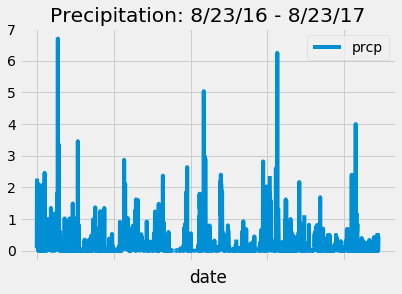

In [44]:
# Calculate the date 1 year ago from the last data point in the databas


last_date = list(np.ravel(last_date))[0]

last_date = dt.datetime.strptime(last_date, '%Y-%m-%d')

#extract year, month, and day
year = int(dt.datetime.strftime(last_date, '%Y'))
month = int(dt.datetime.strftime(last_date, '%m'))
day = int(dt.datetime.strftime(last_date, '%d'))


year_before = dt.date(year, month, day) - dt.timedelta(days=365)

#query
r_date = (session.query(Measurement.date, Measurement.prcp)
                  .filter(Measurement.date > year_before)
                  .order_by(Measurement.date)
                  .all())

#object to data frame and set index
r_table = pd.DataFrame(r_date)
r_table = r_table.set_index('date')

#sort
r_table = r_table.sort_index(ascending=True)

#plot
r_table.plot(title="Precipitation: 8/23/16 - 8/23/17")


In [45]:
# Use Pandas to calcualte the summary statistics for the precipitation data
r_table.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [48]:
# Design a query to show how many stations are available in this dataset?
count_station = session.query(Station).count()
print(count_station)

9


In [49]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
count_station = (session.query(Measurement.station, func.count(Measurement.station))
                        .group_by(Measurement.station)
                        .order_by(func.count(Measurement.station).desc())
                        .all())
count_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [56]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
#set the most active station
stationID = count_station[0][0]

name = (session.query(Station.name)
                      .filter_by(station = stationID))
name = name[0][0]
print(stationID and name)

#query for highest 
highest_temp = (session.query(Measurement.tobs)
                      .filter(Measurement.station == stationID)
                      .order_by(Measurement.tobs.desc())
                      .first())
highest_temp = highest_temp[0]
print(highest_temp)

#query for lowest 
lowest_temp = (session.query(Measurement.tobs)
                     .filter(Measurement.station == stationID)
                     .order_by(Measurement.tobs.asc())
                     .first())
lowest_temp = lowest_temp[0]
print(lowest_temp)

#query for average 
avg_temp = (session.query(func.avg(Measurement.tobs))
                  .filter(Measurement.station == stationID))
avg_temp = '{0:.3}'.format(avg_temp[0][0])
print(avg_temp)



WAIHEE 837.5, HI US
85.0
54.0
71.7


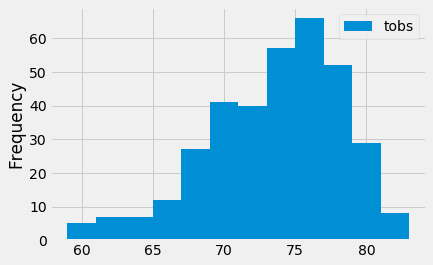

In [58]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


temp = (session.query(Measurement.date, Measurement.tobs)
                   .filter(Measurement.date > yearBefore)
                   .filter(Measurement.station == stationID)
                   .order_by(Measurement.date)
                   .all())

temp_table = pd.DataFrame(temp)
temp_table = temp_table.set_index('date')

#sory 
temp_table = temp_table.sort_index(ascending=True)

#histogram 
temp_table.plot(kind='hist', bins=12)

In [73]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [74]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_dates = '2019-04-08 to \n 2019-04-19'
start_date = '2017-04-08'
end_date = '2017-04-19'

#calculate the tmin, tavg, and tmax 
temp = calc_temps(start_date, end_date)

temp

[(67.0, 73.6, 83.0)]

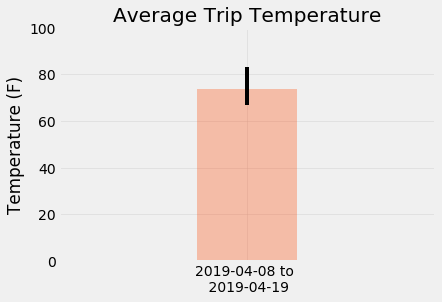

In [67]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


min_ = temp[0][0]
avg = temp[0][1]
max_ = temp[0][2]

min_error = avg - min_
max_error = max_ - avg

errorBars = np.array([[min_error], [max_error]])

plt.bar(trip_dates, avg, yerr=errorBars, color = 'orangered', alpha = .3)
plt.ylim(0, 100)
plt.xlim(-1.5, 1.5)
plt.title('Average Trip Temperature')
plt.ylabel('Temperature (F)')
plt.grid(alpha=.4)

<IPython.core.display.Javascript object>


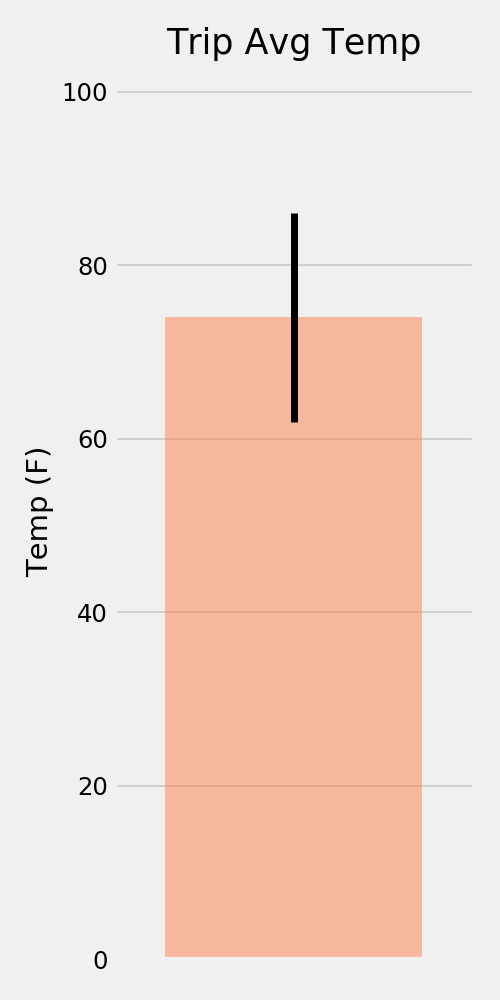

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [71]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
grp = ([Station.station, 
        Station.name, 
        func.sum(Measurement.prcp), 
        Station.latitude, 
        Station.longitude, 
        Station.elevation
       ])

station_rain = (session.query(*grp)
                   .filter(Station.station == Measurement.station)
                   .filter(Measurement.date >= start_date)
                   .filter(Measurement.date <= end_date)
                   .group_by(Station.station)
                   .order_by(func.sum(Measurement.prcp).desc())
                   .all())

#convert query object to data frame
station_r_table = pd.DataFrame(np.array(station_rain))
#rename columns
station_r_table = station_r_table.rename(columns={0: "Station", 1: "Location", 
                                                    2: "Total Precipitation", 3: "Latitude", 
                                                    4: "Longitude", 5: "Elevation"})

station_r_table


,Station,Location,Total Precipitation,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",7.38,21.3331,-157.8025,152.4
1,USC00519281,"WAIHEE 837.5, HI US",6.979999999999999,21.45167,-157.84888999999998,32.9
2,USC00513117,"KANEOHE 838.1, HI US",2.48,21.4234,-157.8015,14.6
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.86,21.5213,-157.8374,7.0
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.8099999999999999,21.33556,-157.71139,19.5
5,USC00519397,"WAIKIKI 717.2, HI US",0.31000000000000005,21.2716,-157.8168,3.0
6,USC00517948,"PEARL CITY, HI US",0.0,21.3934,-157.9751,11.9
